In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import string
import datetime
import tqdm
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import warnings

(c1,c2,c3,c4)=('#1b9e77','#d95f02','#7570b3','#e7298a')

In [3]:
# met_dict = pickle.load(open('met_dict.p','rb'))
stakes = pickle.load(open('/home/robbie/Dropbox/melt_onset_new/pickles/mdf.p','rb'))

# df = pickle.load(open('night_df.p','rb'))
# df = df[~np.isnan(df['stake_depth'])]
solar_dict = pickle.load(open('../../pickles/solar_df','rb'))

dfs_list = []
for station in solar_dict.keys():
    for year in solar_dict[station].keys():
        
        try:
            df = solar_dict[station][year]
            
            df['diff'] = df['tempC'] - df['surface temp']

            df['stake_depth'] = np.nan

            df['doy'] = [dt.timetuple().tm_yday for dt in df['date']]
            
            df['code'] = [f'{dt}_{NP}' for dt, NP in zip(df.index,df['NP'])]
            
            df['days_after_jan1'] = [d  if d<212 else d-365 for d in df['doy']]
            
            df = df[np.isin(df['month'],[1,2,3,4,9,10,11,12])]
            
            df = df[df['surface temp']<0]

            dfs = df.set_index('doy')

            snow = stakes[f'{station}_{int(year)+1900}']

            for i in snow.index:

                sd = snow.loc[i]

                dfs['stake_depth'].loc[i] = sd
            
            dfs = dfs.set_index('code')
                
            dfs_list.append(dfs)
                
        except Exception as e:
            print(e)
    

df = pd.concat(dfs_list)

/home/robbie/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


'19_1969'


In [4]:
rm_dict = pickle.load(open('running_means.p','rb'))
variables=['stake_depth','diff']

anoms = []

for i in tqdm.tqdm(df.index):
    
    row = df.loc[i]
    day = row['days_after_jan1']
    
    d = {'day':day}
    
    for variable in variables:
        
        rm = rm_dict[variable][day]
        val = row[variable]
            
        
        d[f'{variable}_anom'] = val-rm
        
    anoms.append(d)
    
anoms_df = pd.DataFrame(anoms)
anoms_df.index=df.index
df = pd.concat([anoms_df,df],axis=1)


df = df.loc[:,~df.columns.duplicated()].copy()

print(df.shape)

100%|██████████████████████████████████| 10282/10282 [00:00<00:00, 10401.31it/s]


(10282, 26)


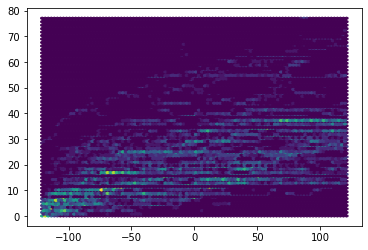

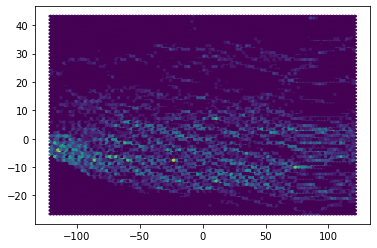

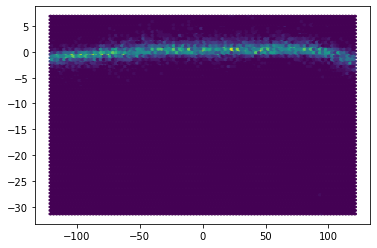

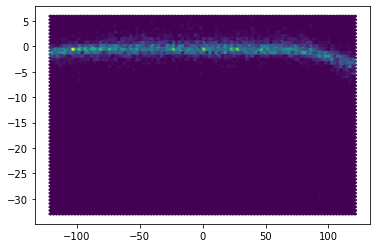

In [5]:
plt.hexbin(df['days_after_jan1'],df['stake_depth'])
# plt.scatter(df['days_after_jan1'],df['SD_running_mean'])

plt.show()

lr = linregress(df['days_after_jan1'],df['stake_depth'])

plt.hexbin(df['days_after_jan1'],df['stake_depth_anom'])

plt.show()

plt.hexbin(df['days_after_jan1'],df['diff'])

plt.show()

plt.hexbin(df['days_after_jan1'],df['diff_anom'])

plt.show()

In [8]:
df.columns

Index(['day', 'stake_depth_anom', 'diff_anom', 'NP', 'year', 'month', 'tempC',
       'RH%', 'pressure hPa', 'wind speed', 'total cloud', 'low cloud',
       'surface temp', 'num obs', 'latitude', 'longitude', 'diffuse radiation',
       'direct radiation', 'global radiation', 'reflected radiation', 'albedo',
       'net radiation', 'date', 'diff', 'stake_depth', 'days_after_jan1'],
      dtype='object')

In [6]:
df_cloudy_low = df[df['Low cloudiness']>9]
df_clear_total = df[df['Total cloudiness']<1]
df_clear_low = df[df['Low cloudiness']<1]
df_cloudy_high = df_clear_low[df_clear_low['Total cloudiness']>8]

KeyError: 'Low cloudiness'

In [ ]:
var = 'stake_depth_anom'
# var = 'stake_depth'

names = ['Low Cloud','High Cloud','Clear Sky']
colors = [c2,c3,c1]

dicts = {n:{} for n in names}

for dfc_,name in zip([df_cloudy_low,df_cloudy_high,df_clear_total],
                       names,
                    ):
    
    r_vals = []
    s_vals = []
    
    for i in np.arange(0,16):
        
        dfc=dfc_.copy()
        
        dfc = dfc[dfc['Wind speed']<i+0.1]
        dfc = dfc[dfc['Wind speed']>i-0.1]
        
        try:
            lr = linregress(dfc[var],dfc['diff_anom'])
#             lr = linregress(dfc['SD_anom'],dfc['diff'])
            p = lr[3]
            if p>0.05:raise
            s = lr[0]
            r = lr[2]
        except:
            r=np.nan
            s=np.nan
            
        r_vals.append(r)
        s_vals.append(s)
        
        if i == 0:
            
            dicts[name]['wind0'] = {'SD':dfc[var],
                                    'BLI':dfc['diff_anom']}
        
    dicts[name]['r'] = r_vals
    dicts[name]['s'] = s_vals
    

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(8,8))

gs = GridSpec(6, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:3,0])
ax2 = fig.add_subplot(gs[3:6,0])
ax3 = fig.add_subplot(gs[0:2,1])
ax4 = fig.add_subplot(gs[2:4,1])
ax5 = fig.add_subplot(gs[4:6,1])

for name,c in zip(names,colors):

    ax1.plot(np.arange(0,16),dicts[name]['r'],marker='o',label=name,color=c)
    ax2.plot(np.arange(0,16),dicts[name]['s'],marker='o',label=name,color=c)
    
ax1.set_xlim(-0.5,10.5)
ax1.set_ylim(0,0.45)
ax1.set_ylabel('Pearson Correlation\nr Value',fontsize='x-large')

ax2.set_ylim(0,0.08)
ax2.set_xlim(-0.5,10.5)
ax2.set_ylabel('Slope of Linear\nRegression ($\degree$C/m)',fontsize='x-large')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

for ax in [ax1,ax2]:
    ax.set_xlabel('Wind Speed (m/s)',fontsize='x-large')
    ax.set_xlim(-0.2,4.5)

ax1.legend(fontsize='x-large')
    

for name,c,ax in zip(names,colors,[ax3,ax4,ax5]):
    ax.scatter(dicts[name]['wind0']['SD'],
               dicts[name]['wind0']['BLI'],
               alpha=0.1,color='k')
    x=np.arange(np.min(df[var]),np.max(df[var]))
    lr = linregress(dicts[name]['wind0']['SD'],
               dicts[name]['wind0']['BLI'])
    
    if lr[2]<0.05:
        ax.annotate(f'r = {np.round(lr[2],2)}\nslope = {np.round(lr[0],3)}',ha='right',va='bottom',xy=(0.97,0.03),fontsize='x-large',xycoords='axes fraction')
        ax.plot(x,x*lr[0]+lr[1],color='r',zorder=5,ls='--')
    ax.axhline(0,color='k',zorder=6,ls='--')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_ylim(-6,12)
    ax.annotate(f'{name}, W = 0',ha='center',va='top',xy=(0.5,0.94),fontsize='x-large',xycoords='axes fraction')
    ax.set_xlim(-30,50)
    
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')

for ax in [ax3,ax5]:
    ax.set_xlabel('Snow Depth Anomaly (cm)',fontsize='x-large')
    
ax4.set_ylabel('Boundary Layer Inversion Strength Anomaly ($\degree$C)',fontsize='x-large')
    
for ax,letter in zip([ax1,ax2,ax3,ax4,ax5],string.ascii_letters):
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="x", direction="inout")
    ax.annotate(f'{letter}',
         xycoords='axes fraction',
         xy=(0.01,0.99),
         va='top',
         fontsize='xx-large')

    
fig.subplots_adjust(hspace=0,wspace=0.07)


# plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/main_figs/snow.png',dpi=400,bbox_inches='tight')

plt.show()

# CORRELATE NOT WITH SNOW DEPTH, BUT WITH SNOW CONDUCTIVITY!

# MAKE ROW 2 OF FIGURE

In [ ]:
df = pd.concat(frames)
df['month'] = [x.month for x in df.index]
df = df[np.isin(df['month'],[1,2,3,4,9,10,11,12])]
# df = df[df['zenith']>90]
df = df[df['Surface temperature']<1]
df = df[~np.isnan(df['stake_depth'])]


lr = linregress(df['days_after_jan1'],df['stake_depth'])

df['SD_anom'] = df['stake_depth']-(lr[0]*df['days_after_jan1'] + lr[1])


df_cloudy_low = df[df['Low cloudiness']>9]
df_clear_total = df[df['Total cloudiness']<1]
df_clear_low = df[df['Low cloudiness']<1]
df_cloudy_high = df_clear_low[df_clear_low['Total cloudiness']>8]

regs = {'low' :{'slope':0.06745,'int':-6.129},
               'high':{'slope':0.12470,'int':-10.4437},
               'clear'  :{'slope':0.20727,'int':-16.8172}}

df['code'] = [str(t)+np for (t,np) in zip(df.index,df['NP'])]

print(df.shape)

In [ ]:
dens_file = '/home/robbie/Dropbox/sub_km/NP_transects/transect_densities.xlsx'

densities = {}
for station in np.arange(5,32):
    
    try:
        sheet = pd.read_excel(dens_file,sheet_name=str(station),parse_dates=True)
        densities[station] = sheet
    except:
        pass
    

def get_density(station,date):
    
    try:
        sheet = densities[int(station)]
    except:
        return np.nan
    
    dates = np.array([d.date() for d in sheet.columns[1:]])
    
    date_anoms = np.array([(date-d).days for d in dates])
    
    future_dates = dates[date_anoms<0]
    past_dates = dates[date_anoms>0]

    if future_dates.shape[0] and past_dates.shape[0]:
        a = future_dates[0]
        b = past_dates[-1]
#         print(a,b)
        am = np.nanmean(sheet[datetime.datetime(a.year,a.month,a.day)])
        bm = np.nanmean(sheet[datetime.datetime(b.year,b.month,b.day)])
        mean_density = (am+bm)/2
        
    else:
        nearest_date = dates[np.argmin(np.abs(date_anoms))]

        distance = np.min(np.abs(date_anoms))

        nd = nearest_date

        mean_density = np.nanmean(sheet[datetime.datetime(nd.year,nd.month,nd.day)])
    
        if distance>20:
            mean_density=np.nan
            
    return mean_density

df['date'] = [d.date() for d in df.index]

# df['density'] = [get_density(station,date) for (station,date) in zip(df['NP'],df['date'])]

dens = []
for (station,date) in tqdm.tqdm(list(zip(df['NP'],df['date']))):
    dens.append(get_density(station,date))
    
df['density'] = np.array(dens)*100

In [ ]:
df_dens = df.copy()
x = df_dens.dropna()

def get_k(rho):
    
    """Generates a thermal conductivity (W/m3/K) from density.
    
    This is the heat that flows per second through 1m2 area 
    per metre of thickness per degree of temperature difference.
    
    From Calonne et al. (2011).
    
    https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049234
    
    """
    
    k = ( 2.5 * 10**(-6) * rho**2 ) - (1.23 * 10**(-4) * rho ) + 0.024
    
    return k

def get_abs_k(depth, k_per_metre):
    
    """This generates the absolute thermal conductivity for snow of given depth.
    
    This is the heat that flows through a square metre of snow per degree of temp diff.
    
    """

    k_abs = k_per_metre / depth
    
    return k_abs #W/m2K

x['cond'] = get_abs_k(x['stake_depth'],get_k(x['density']))

x = x[x['cond']<1]

x.dropna(inplace=True,axis=1)

x.shape

In [ ]:
linregress(x['stake_depth'][:-1],x['diff'][:-1])

# Deeper snow is associated with colder snow relative to the air.

# So deeper snow accentuates the difference between snow and air when the snow is cold. But it limits the difference when the snow is relatively warm. 


# Why? Because thicker snow simply reduces heat flow from the ice. And heat *almost always* flows from the ice to the snow surface.

# This implies that the role of snow is not mediated by ice roughness - as that would simply act to reduce the temperature difference between ice and air..

In [ ]:
import operator

In [ ]:
thresh = -1.8

for op in ['lt','mt']:

    for dfc_,name in zip([df_cloudy_low,df_cloudy_high,df_clear_total],['low','high','clear']):

        dfc_['diff_expectation'] = (regs[name]['slope']*dfc_['zenith']+regs[name]['int'])

        dfc_['z_anomaly'] = dfc_['diff']-dfc_['diff_expectation']

        dfc=dfc_.copy()
        
        var = 'Air Temperature'

        if op =='lt':
            print('less_than')
            dfc = dfc[dfc[var]<thresh]
        else:
            print('more_than')
            dfc = dfc[dfc[var]>thresh]
            
        dfc = dfc[dfc['diff_expectation']<0]
        
#         dfc = dfc[dfc['stake_depth']]

        dfc.dropna(inplace=True)

        lr = linregress(dfc['SD_anom'],dfc['z_anomaly'])
        p = lr[3]
        s = lr[0]
        r = lr[2]
        print(dfc.shape[0])
        print(lr)
    print()

In [ ]:
for dfc_,name in zip([df_cloudy_low,df_cloudy_high,df_clear_total],['low','high','clear']):
    
    dfc_['diff_expectation'] = (regs[name]['slope']*dfc_['zenith']+regs[name]['int'])
    
    dfc_['z_anomaly'] = dfc_['diff']-dfc_['diff_expectation']
    

    dfc=dfc_.copy()


    dfc = dfc[dfc['stake_depth']<60]
    
    dfc = dfc[dfc['Air temperature']<-1.8]
    
    dfc = dfc[dfc['diff_expectation']<0]

    lr = linregress(dfc['stake_depth'],dfc['z_anomaly'])
    p = lr[3]
    s = lr[0]
    r = lr[2]
    print(dfc.shape[0])
    print(lr)

In [ ]:
plt.figure(figsize=(10,8))
plt.hexbin(df['days_after_jan1'],df['diff'])
plt.ylim(-5,5)

In [ ]:
plt.figure(figsize=(10,8))
plt.hexbin(df['days_after_jan1'],df['stake_depth'])
# plt.ylim(-5,5)

In [ ]:
plt.hexbin(df['days_after_jan1'],df['Air temperature'])

In [ ]:
linregress(df['diff'],df['Air temperature'])

In [ ]:
from sklearn import linear_model

In [ ]:

for d in [df_cloudy_high,df_clear_total]:

    lr = linregress(d['diff'],d['Air temperature'])[2]**2
    print(lr)
    
    
    lr = linregress(d['diff'],d['stake_depth'])[2]**2
    print(lr)
    
    print()

In [ ]:
regr = linear_model.LinearRegression()

inputs = d[['Air temperature','stake_depth']]

r = regr.fit(inputs,d['diff'])

r.score(inputs,d['diff'])